import /content/drive/MyDrive/v2x_data/veremi_stratified_200000.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)




Mounted at /content/drive


In [2]:
from datetime import datetime

# Get current date and time
now = datetime.now()

# Print formatted datetime
print("Current date and time:", now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time: 2025-06-15 15:34:41


In [3]:
import zipfile
zip_path = '/content/drive/MyDrive/v2x_data/veremi_stratified_200000.zip'
extract_dir = '/content/veremi_subsets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipped to:", extract_dir)


Unzipped to: /content/veremi_subsets


In [4]:
import pandas as pd

df_balanced = pd.read_csv('/content/veremi_subsets/veremi_stratified_200000.csv')
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   type          200000 non-null  int64  
 1   sendTime      200000 non-null  float64
 2   sender        200000 non-null  int64  
 3   senderPseudo  200000 non-null  int64  
 4   messageID     200000 non-null  int64  
 5   class         200000 non-null  int64  
 6   posx          200000 non-null  float64
 7   posy          200000 non-null  float64
 8   posz          200000 non-null  float64
 9   spdx          200000 non-null  float64
 10  spdy          200000 non-null  float64
 11  spdz          200000 non-null  float64
 12  aclx          200000 non-null  float64
 13  acly          200000 non-null  float64
 14  aclz          200000 non-null  float64
 15  hedx          200000 non-null  float64
 16  hedy          200000 non-null  float64
 17  hedz          200000 non-null  float64
 18  Atta

In [5]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd

# Define subset sizes
subset_sizes = [20000, 40000, 80000, 120000, 160000, 200000]

# Split normal and attack records
df_normal = df_balanced[df_balanced['binary_label'] == 0]
df_attack = df_balanced[df_balanced['binary_label'] == 1]
attack_class_proportions = df_attack['class'].value_counts(normalize=True)

# Initialize tracking DataFrame
subset_class_summary = pd.DataFrame()

for size in subset_sizes:
    n_attack = size // 2
    n_normal = size // 2

    # Stratified attack sampling
    attack_samples = []
    for cls, frac in attack_class_proportions.items():
        cls_pool = df_attack[df_attack['class'] == cls]
        n_cls = min(len(cls_pool), int(n_attack * frac))
        attack_samples.append(cls_pool.sample(n=n_cls, random_state=42))
    attack_subset = pd.concat(attack_samples)

    # Pad with extra if needed
    if len(attack_subset) < n_attack:
        remaining = n_attack - len(attack_subset)
        extra = df_attack.drop(attack_subset.index).sample(n=remaining, random_state=42)
        attack_subset = pd.concat([attack_subset, extra])

    # Normal class sampling
    normal_subset = df_normal.sample(n=n_normal, random_state=42)

    # Combine and shuffle
    df_subset = shuffle(pd.concat([attack_subset, normal_subset]), random_state=42).reset_index(drop=True)

    # Save to file
    df_subset.to_csv(f'veremi_stratified_{size}.csv', index=False)
    print(f"\n Saved veremi_stratified_{size}.csv with {len(df_subset)} records")
    print(df_subset["binary_label"].value_counts())
    # ---- Plot distributions ----
    binary_counts = df_subset['binary_label'].value_counts(normalize=True) * 100
    class_counts = df_subset['class'].value_counts(normalize=True).sort_index() * 100
    # ---- Track class distribution for summary ----
    class_row = class_counts.copy()
    class_row['subset_size'] = size
    subset_class_summary = pd.concat([subset_class_summary, class_row.to_frame().T], ignore_index=True)
    print("------------")

# ---- Final formatting ----
subset_class_summary = subset_class_summary.set_index('subset_size')
subset_class_summary.index.name = 'Sample Size'
subset_class_summary = subset_class_summary[sorted(subset_class_summary.columns, key=lambda x: int(x))]
subset_class_summary = subset_class_summary.fillna(0)
subset_class_summary.head(10)


 Saved veremi_stratified_20000.csv with 20000 records
binary_label
0    10000
1    10000
Name: count, dtype: int64
------------

 Saved veremi_stratified_40000.csv with 40000 records
binary_label
0    20000
1    20000
Name: count, dtype: int64
------------

 Saved veremi_stratified_80000.csv with 80000 records
binary_label
0    40000
1    40000
Name: count, dtype: int64
------------

 Saved veremi_stratified_120000.csv with 120000 records
binary_label
0    60000
1    60000
Name: count, dtype: int64
------------

 Saved veremi_stratified_160000.csv with 160000 records
binary_label
0    80000
1    80000
Name: count, dtype: int64
------------

 Saved veremi_stratified_200000.csv with 200000 records
binary_label
0    100000
1    100000
Name: count, dtype: int64
------------


class,0,9,10,11,12,13,14,15,16,17,18,19
Sample Size,,,,,,,,,,,,
20000.0,50.0,2.2500,2.2750,2.335000,2.2700,6.91500,6.675000,6.805000,9.250000,2.3300,4.5750,4.320000
40000.0,50.0,2.2525,2.2775,2.335000,2.2700,6.91500,6.675000,6.810000,9.235000,2.3325,4.5750,4.322500
80000.0,50.0,2.2525,2.2775,2.335000,2.2700,6.91625,6.672500,6.807500,9.238750,2.3325,4.5750,4.322500
120000.0,50.0,2.2525,2.2775,2.335000,2.2700,6.91500,6.674167,6.807500,9.236667,2.3325,4.5750,4.324167
160000.0,50.0,2.2525,2.2775,2.335625,2.2700,6.91625,6.673750,6.808125,9.235625,2.3325,4.5750,4.323125
200000.0,50.0,2.2530,2.2780,2.335000,2.2705,6.91500,6.673500,6.807500,9.236000,2.3330,4.5755,4.323000


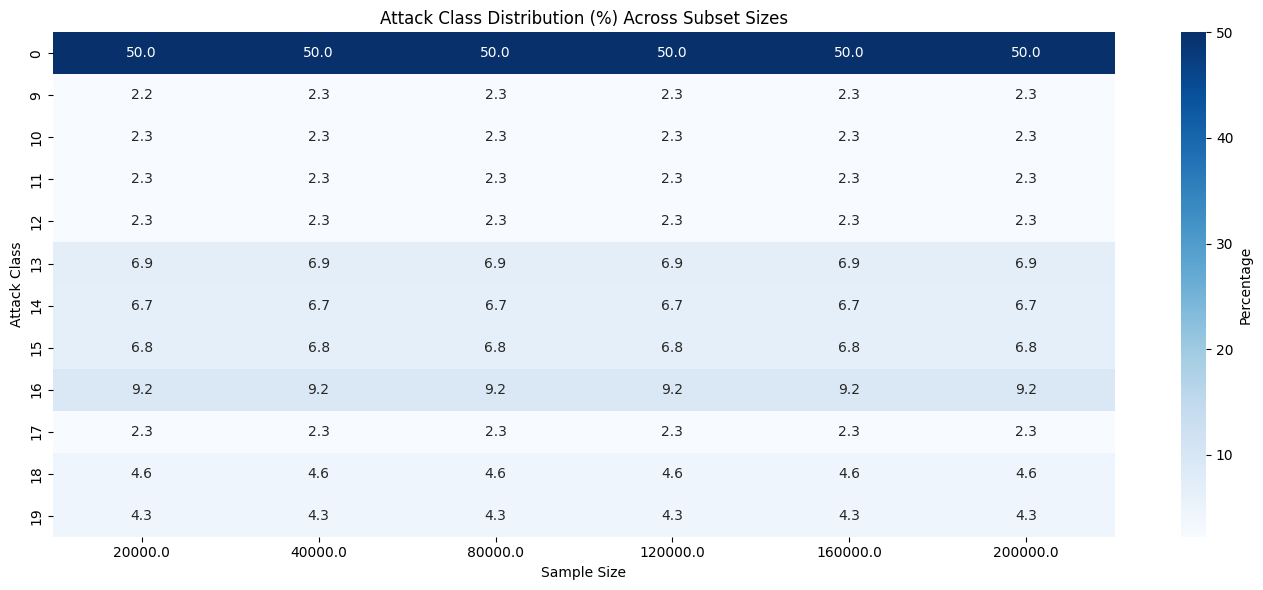

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.heatmap(subset_class_summary.T, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Percentage'})

plt.title("Attack Class Distribution (%) Across Subset Sizes")
plt.xlabel("Sample Size")
plt.ylabel("Attack Class")
plt.tight_layout()
plt.show()


In [7]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Melt DataFrame to long format
df_long = subset_class_summary.reset_index().melt(id_vars='Sample Size', var_name='Attack Class', value_name='Percentage')
df_long['Attack Class'] = df_long['Attack Class'].astype(str)

# Generate distinct colors for each class using a colormap
unique_classes = sorted(df_long['Attack Class'].unique(), key=lambda x: int(x))
color_map = cm.get_cmap('tab20', len(unique_classes))
class_colors = {cls: mcolors.to_hex(color_map(i)) for i, cls in enumerate(unique_classes)}

# Create 3D lines for each (Sample Size, Attack Class)
fig = go.Figure()

for _, row in df_long.iterrows():
    x = row['Sample Size']
    y = row['Attack Class']
    z = row['Percentage']
    color = class_colors[y]

    fig.add_trace(go.Scatter3d(
        x=[x, x],
        y=[y, y],
        z=[0, z],
        mode='lines',
        line=dict(color=color, width=10),
        name=f'Class {y}',
        showlegend=False,
        hovertemplate=f"Sample Size: {x}<br>Attack Class: {y}<br>Percentage: {z:.2f}%<extra></extra>"
    ))

# Add legend entries manually (one per class)
for cls, color in class_colors.items():
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode='lines',
        line=dict(color=color, width=10),
        name=f'Class {cls}',
        showlegend=True
    ))

# Layout
fig.update_layout(
    title="3D Class-Wise Distribution Across Sample Sizes",
    scene=dict(
        xaxis_title='Sample Size',
        yaxis_title='Attack Class',
        zaxis_title='Percentage',
    ),
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()


<ipython-input-7-981602176>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(unique_classes))


## LSTM TESTING 20000

In [8]:
import pandas as pd

df = pd.read_csv('/content/veremi_stratified_20000.csv')
df.info()
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          20000 non-null  int64  
 1   sendTime      20000 non-null  float64
 2   sender        20000 non-null  int64  
 3   senderPseudo  20000 non-null  int64  
 4   messageID     20000 non-null  int64  
 5   class         20000 non-null  int64  
 6   posx          20000 non-null  float64
 7   posy          20000 non-null  float64
 8   posz          20000 non-null  float64
 9   spdx          20000 non-null  float64
 10  spdy          20000 non-null  float64
 11  spdz          20000 non-null  float64
 12  aclx          20000 non-null  float64
 13  acly          20000 non-null  float64
 14  aclz          20000 non-null  float64
 15  hedx          20000 non-null  float64
 16  hedy          20000 non-null  float64
 17  hedz          20000 non-null  float64
 18  Attack        20000 non-nu

,type,sendTime,sender,senderPseudo,messageID,class,posx,posy,posz,spdx,...,spdz,aclx,acly,aclz,hedx,hedy,hedz,Attack,Attack_type,binary_label
0,4,56645.238071,81621,10816215,244255294,0,249.824980,405.237117,0.0,-6.011002,...,0.0,2.751941,2.062643,0.0,-0.804021,-0.594600,0.0,Normal,Normal behavior,0
1,4,62703.878111,94773,10947736,282677119,13,1180.833832,784.077835,0.0,-9.630062,...,0.0,0.378693,0.408204,0.0,-0.719064,-0.694944,0.0,Attack,DoS disruptive,1
2,4,48553.276086,67671,10676714,202740336,10,920.863634,628.141824,0.0,3.410431,...,0.0,-1.318903,-2.977396,0.0,0.445309,0.895377,0.0,Attack,Data replay,1
3,4,28123.107181,18975,20189752,45141196,16,916.104651,621.375901,0.0,-1.454104,...,0.0,-1.466771,-3.105949,0.0,0.471753,0.881731,0.0,Attack,DoS random sybil,1
4,4,24903.305602,9729,1097292,16869316,0,899.948212,589.091061,0.0,6.965031,...,0.0,-0.369491,-0.558042,0.0,0.671635,0.740882,0.0,Normal,Normal behavior,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4,67645.466708,113763,101137636,358613707,0,273.868611,423.324800,0.0,-9.250936,...,0.0,2.193360,1.751994,0.0,-0.909155,-0.416458,0.0,Normal,Normal behavior,0
19996,4,33963.614750,39897,10398973,125038911,0,161.859199,718.821045,0.0,-1.960121,...,0.0,-0.009112,0.061856,0.0,-0.044394,0.999014,0.0,Normal,Normal behavior,0
19997,4,65171.490107,104073,101040736,319716230,14,657.564877,779.357255,0.0,13.719221,...,0.0,0.847514,1.799761,0.0,-0.670660,-0.728144,0.0,Attack,Data replay sybil,1
19998,4,29324.745671,23535,20235352,61461778,16,1390.291153,1148.072546,0.0,0.301333,...,0.0,0.291288,0.821085,0.0,-0.375159,-0.926960,0.0,Attack,DoS random sybil,1


preprocessing pipeline

* Loads the CSV
* Drops irrelevant columns
* Normalizes with StandardScaler
* Reshapes for LSTM
* Splits into train/test sets
* Returns all ready-to-train arrays

In [9]:
# STEP 1: Install TensorFlow (only once)
!pip install tensorflow


In [10]:
# STEP 2: Imports
import pandas as pd
import numpy as np
import time
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense


In [11]:
# STEP 3: Load or Initialize Results DataFrame
try:
    results_df = pd.read_csv("/content/gru_test_results.csv")
    print("Loaded previous results")
except FileNotFoundError:
    results_df = pd.DataFrame(columns=[
        'Timestamp', 'Model', 'Dataset', 'Sample Size', 'Training Time (s)', 'Best Epoch','Accuracy', 'Precision', 'Recall', 'F1 Score',
        'Confusion Matrix', 'CPU Usage (%)', 'Memory Usage (MB)', 'Model Size (MB)', 'Inference Time (s)'
    ])
    print("Created new results table")


Created new results table


* 90:5:5 train/val/test split
* Validation accuracy tracking
* Early stopping to prevent overfitting
* Train/validation loss/accuracy plots

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def prepare_gru_dataset(file_path, random_state=42):
    df = pd.read_csv(file_path)
    drop_cols = ['Attack', 'Attack_type', 'class', 'binary_label', 'messageID', 'sender', 'senderPseudo']
    X = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    y = df['binary_label'].values

    # Normalize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 90% train, 5% val, 5% test
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.10, stratify=y, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state)

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, X_val, X_test, y_train, y_val, y_test, len(df)



GRU_64_32

GRU_64_32_32 (stacked)

GRU_128_64_32

GRUBD_128_64_32 (bidirectional)

In [13]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt
import psutil
import time
import numpy as np
import os

def train_and_evaluate_gru(xModel, X_train, X_val, X_test, y_train, y_val, y_test, dataset_name, sample_size, results_df):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    model_path = f'{sample_size}_{xModel}_mcp_{timestamp}.keras'

    # ✅ Model selection
    if xModel == "GRU_64_32":
        model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            GRU(64),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    elif xModel == "GRU_64_32_32":
        model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            GRU(64, return_sequences=True),
            GRU(32),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    elif xModel == "GRU_128_64_32":
        model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            GRU(128),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    elif xModel == "GRUBD_128_64_32":
        model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            Bidirectional(GRU(64)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    else:
        raise ValueError(f"Unknown model type: {xModel}")

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

    # Training
    train_start = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    training_time = time.time() - train_start

    # Load best checkpoint
    model = load_model(model_path)

    # Inference
    infer_start = time.time()
    y_pred_prob = model.predict(X_test).ravel()
    inference_time = (time.time() - infer_start) / len(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    best_epoch = np.argmin(history.history['val_loss']) + 1
    patience_used = len(history.history['val_loss']) - best_epoch

    cpu_usage = psutil.cpu_percent(interval=1)
    memory_usage = psutil.virtual_memory().used / (1024 ** 2)
    model_size = os.path.getsize(model_path) / (1024 * 1024)

    # Log results
    results_df.loc[len(results_df)] = {
        'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Model': xModel,
        'Dataset': dataset_name,
        'Sample Size': sample_size,
        'Training Time (s)': round(training_time, 2),
        'Best Epoch': best_epoch,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'Confusion Matrix': str(cm),
        'CPU Usage (%)': cpu_usage,
        'Memory Usage (MB)': round(memory_usage, 2),
        'Model Size (MB)': model_size,
        'Inference Time (s)': round(inference_time, 6)
    }

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axvline(x=best_epoch - 1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.axvline(x=best_epoch - 1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Early stopping triggered. Best epoch: {best_epoch}, patience used: {patience_used}")
    print(f"Best model saved to: {model_path}")

    return results_df


In [14]:
import matplotlib.pyplot as plt

def save_and_visualize_results(results_df, xmarker='o', save_path="gru_test_results.csv"):
    # Save to CSV
    results_df.to_csv(save_path, index=False)
    print(f"Results saved to {save_path}")

    # Plot selected metrics as markers only (no connecting lines)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        plt.scatter(results_df['Sample Size'], results_df[metric], marker=xmarker, label=metric)

    plt.xlabel("Sample Size")
    plt.ylabel("Score")
    plt.title("LSTM Classification Metrics by Sample Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Display last result row
    from IPython.display import display
    display(results_df.tail(1))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6043 - loss: 0.6383
Epoch 1: val_loss improved from inf to 0.58321, saving model to 20000_GRU_64_32_mcp_2025-06-15_15-35-20.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6046 - loss: 0.6380 - val_accuracy: 0.6750 - val_loss: 0.5832
Epoch 2/50
279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6726 - loss: 0.5746
Epoch 2: val_loss improved from 0.58321 to 0.56880, saving model to 20000_GRU_64_32_mcp_2025-06-15_15-35-20.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6727 - loss: 0.5746 - val_accuracy: 0.6690 - val_loss: 0.5688
Epoch 3/50
279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6895 - loss: 0.5612
Epoch 3: val_loss improved from 0.56880 to 0.56066, saving model to 20000_GRU_64_32_mcp_2025-06-15_15-35-20.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6895 - loss: 0.5612 - val_accuracy: 0.6720 - val_loss: 0.5607
Epoch 4/50
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

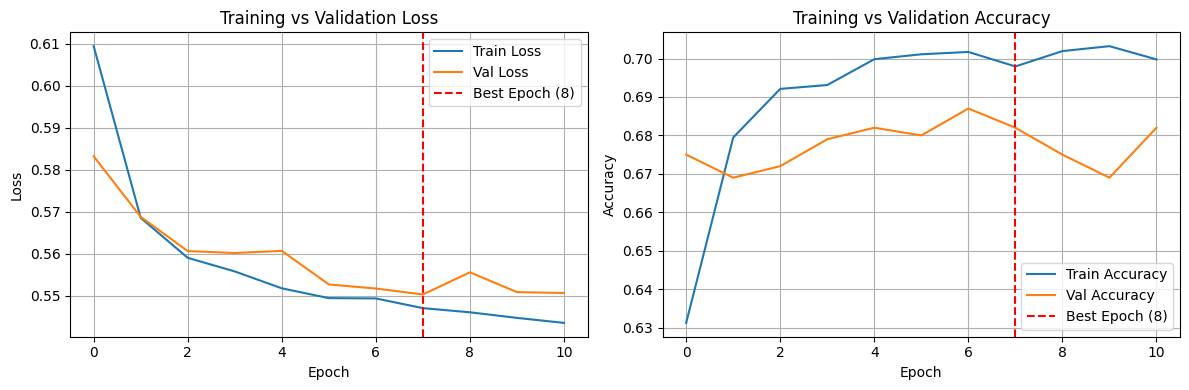

Early stopping triggered. Best epoch: 8, patience used: 3
Best model saved to: 20000_GRU_64_32_mcp_2025-06-15_15-35-20.keras


In [15]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_20000.csv')
results_df = train_and_evaluate_gru("GRU_64_32", X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000.csv', sample_size, results_df)


Results saved to gru_test_results.csv


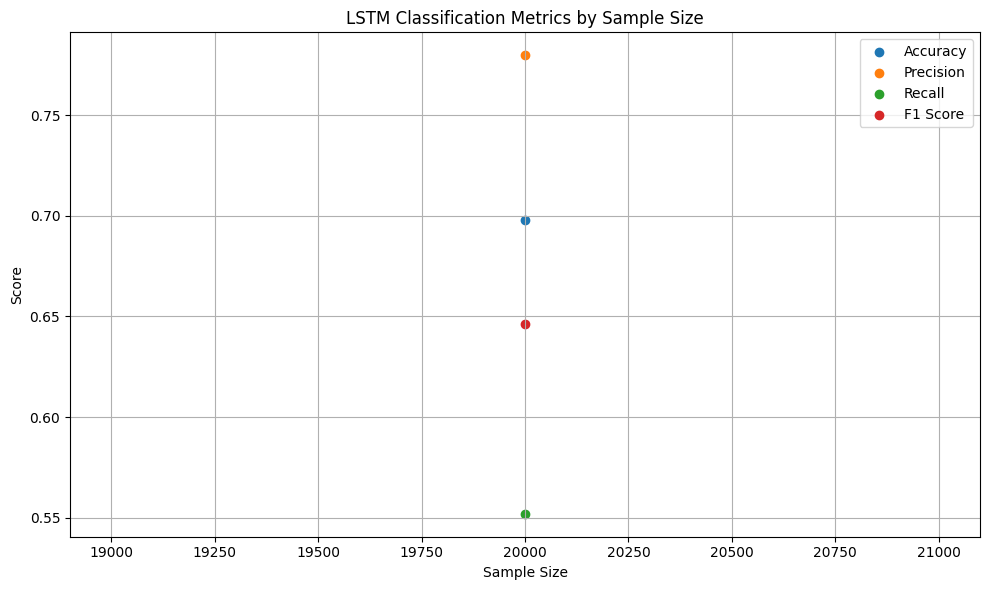

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
0,2025-06-15 15:35:56,GRU_64_32,veremi_stratified_20000.csv,20000,34.47,8,0.698,0.779661,0.552,0.64637,[[422 78]\n [224 276]],2.5,1630.47,0.229708,0.000679


In [16]:
save_and_visualize_results(results_df)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
555/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6158 - loss: 0.6197
Epoch 1: val_loss improved from inf to 0.55907, saving model to 40000_GRU_64_32_mcp_2025-06-15_15-35-57.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6164 - loss: 0.6192 - val_accuracy: 0.6900 - val_loss: 0.5591
Epoch 2/50
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6929 - loss: 0.5586
Epoch 2: val_loss improved from 0.55907 to 0.54983, saving model to 40000_GRU_64_32_mcp_2025-06-15_15-35-57.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6929 - loss: 0.5586 - val_accuracy: 0.6955 - val_loss: 0.5498
Epoch 3/50
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6945 - loss: 0.5516
Epoch 3: val_loss improved from 0.54983 to 0.54852, saving model to 40000_GRU_64_32_mcp_2025-06-15_15-35-57.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6945 - loss: 0.5516 - val_accuracy: 0.6940 - val_loss: 0.5485
Epoch 4/50
548/563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

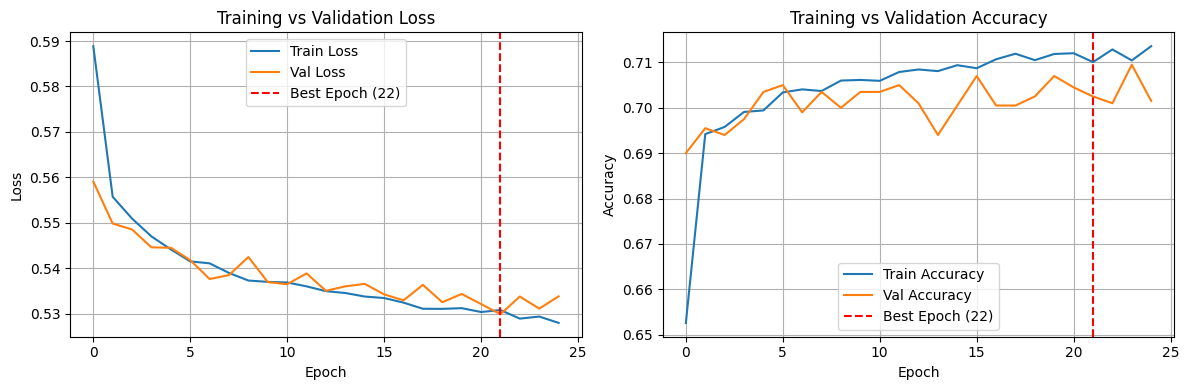

Early stopping triggered. Best epoch: 22, patience used: 3
Best model saved to: 40000_GRU_64_32_mcp_2025-06-15_15-35-57.keras
Results saved to gru_test_results.csv


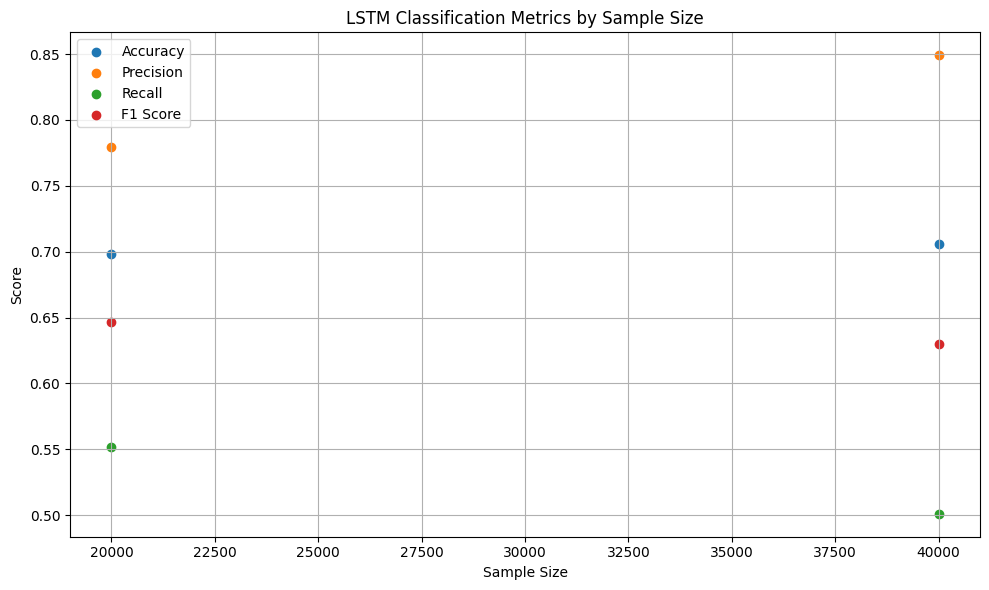

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
1,2025-06-15 15:37:09,GRU_64_32,veremi_stratified_20000.csv,40000,69.29,22,0.706,0.849153,0.501,0.630189,[[911 89]\n [499 501]],2.5,1660.05,0.229717,0.000338


In [17]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_40000.csv')
results_df = train_and_evaluate_gru("GRU_64_32", X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000.csv', sample_size, results_df)
save_and_visualize_results(results_df)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 64)             │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6398 - loss: 0.5976
Epoch 1: val_loss improved from inf to 0.55459, saving model to 80000_GRU_64_32_mcp_2025-06-15_15-37-10.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6399 - loss: 0.5975 - val_accuracy: 0.6915 - val_loss: 0.5546
Epoch 2/50
1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6984 - loss: 0.5520
Epoch 2: val_loss improved from 0.55459 to 0.54461, saving model to 80000_GRU_64_32_mcp_2025-06-15_15-37-10.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6984 - loss: 0.5520 - val_accuracy: 0.6965 - val_loss: 0.5446
Epoch 3/50
1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7031 - loss: 0.5449
Epoch 3: val_loss improved from 0.54461 to 0.53742, saving model to 80000_GRU_64_32_mcp_2025-06-15_15-37-10.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7031 - loss: 0.5449 - val_accuracy: 0.6995 - val_loss: 0.5374
Epoch 4/50
1120/1125 ━━━━━━━━━━━━━━━━━━━━

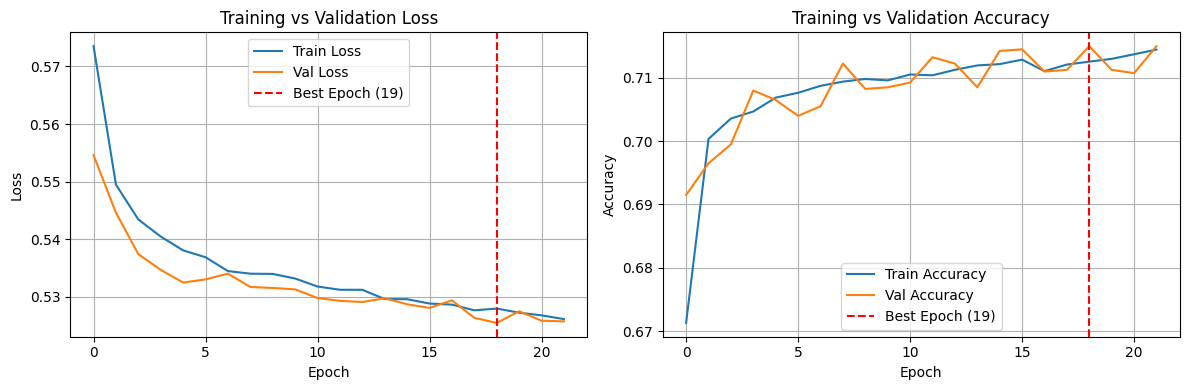

Early stopping triggered. Best epoch: 19, patience used: 3
Best model saved to: 80000_GRU_64_32_mcp_2025-06-15_15-37-10.keras
Results saved to gru_test_results.csv


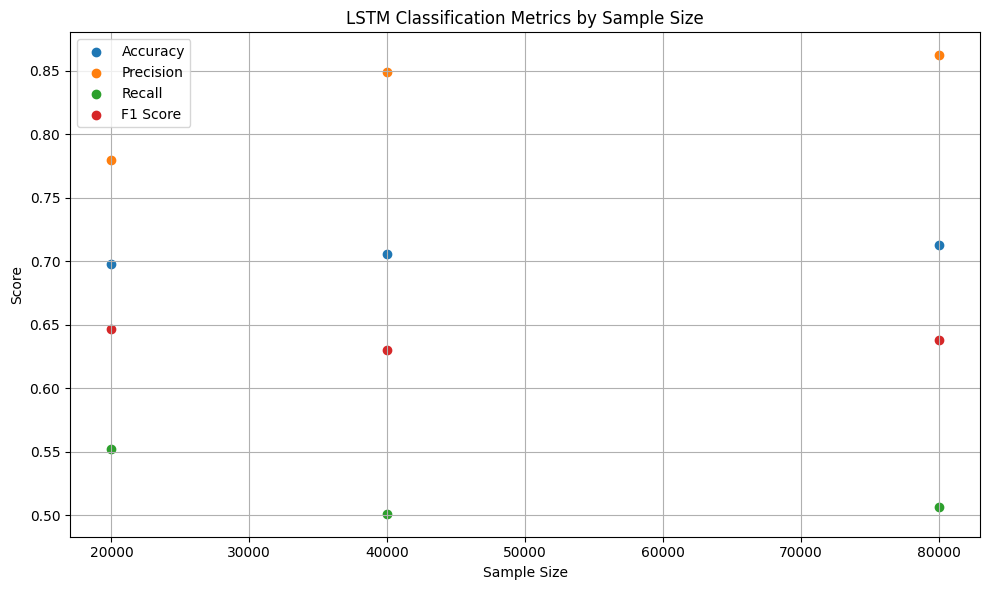

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
2,2025-06-15 15:38:59,GRU_64_32,veremi_stratified_20000.csv,80000,107.3,19,0.71275,0.862128,0.5065,0.63811,[[1838 162]\n [ 987 1013]],2.5,1623.29,0.229717,0.00017


In [18]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_80000.csv')
results_df = train_and_evaluate_gru("GRU_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000.csv', sample_size, results_df)
save_and_visualize_results(results_df)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 64)             │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1681/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6531 - loss: 0.5907
Epoch 1: val_loss improved from inf to 0.54483, saving model to 120000_GRU_64_32_mcp_2025-06-15_15-39-01.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6532 - loss: 0.5905 - val_accuracy: 0.7047 - val_loss: 0.5448
Epoch 2/50
1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6998 - loss: 0.5483
Epoch 2: val_loss improved from 0.54483 to 0.53862, saving model to 120000_GRU_64_32_mcp_2025-06-15_15-39-01.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6998 - loss: 0.5483 - val_accuracy: 0.7070 - val_loss: 0.5386
Epoch 3/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7011 - loss: 0.5440
Epoch 3: val_loss improved from 0.53862 to 0.53409, saving model to 120000_GRU_64_32_mcp_2025-06-15_15-39-01.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7011 - loss: 0.5440 - val_accuracy: 0.7097 - val_loss: 0.5341
Epoch 4/50
1687/1688 ━━━━━━━━━━━━━━━

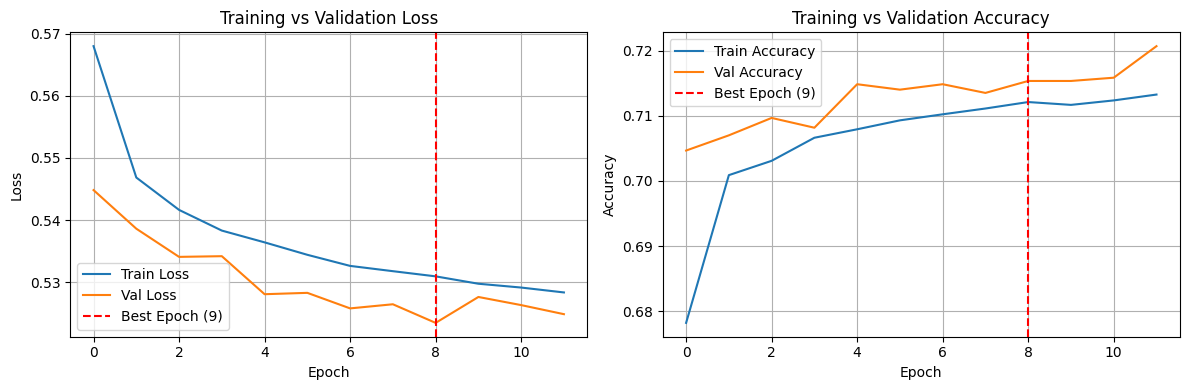

Early stopping triggered. Best epoch: 9, patience used: 3
Best model saved to: 120000_GRU_64_32_mcp_2025-06-15_15-39-01.keras
Results saved to gru_test_results.csv


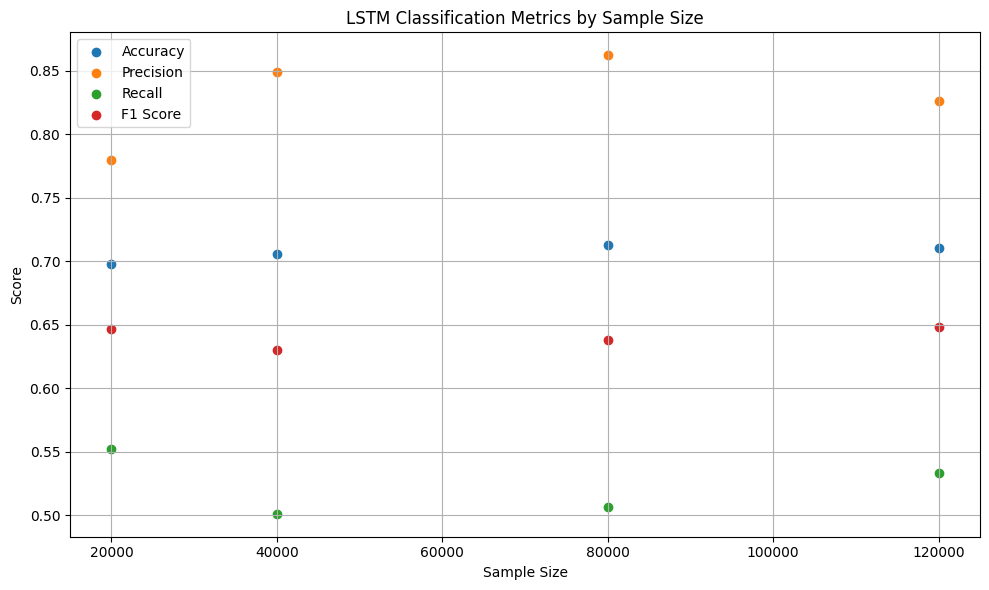

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
3,2025-06-15 15:40:53,GRU_64_32,veremi_stratified_120000.csv,120000,109.6,9,0.7105,0.826357,0.533,0.648024,[[2664 336]\n [1401 1599]],2.0,1653.92,0.229717,0.00022


In [19]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_120000.csv')
results_df = train_and_evaluate_gru("GRU_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_120000.csv', sample_size, results_df)
save_and_visualize_results(results_df)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_160000.csv')
results_df = train_and_evaluate_gru("GRU_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_160000.csv', sample_size, results_df)
save_and_visualize_results(results_df)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 64)             │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2234/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6641 - loss: 0.5817
Epoch 1: val_loss improved from inf to 0.54497, saving model to 160000_GRU_64_32_mcp_2025-06-15_15-40-55.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6643 - loss: 0.5816 - val_accuracy: 0.7006 - val_loss: 0.5450
Epoch 2/50
2248/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7017 - loss: 0.5446
Epoch 2: val_loss improved from 0.54497 to 0.54066, saving model to 160000_GRU_64_32_mcp_2025-06-15_15-40-55.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7017 - loss: 0.5446 - val_accuracy: 0.7025 - val_loss: 0.5407
Epoch 3/50
2235/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7046 - loss: 0.5401
Epoch 3: val_loss improved from 0.54066 to 0.53881, saving model to 160000_GRU_64_32_mcp_2025-06-15_15-40-55.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7046 - loss: 0.5401 - val_accuracy: 0.7025 - val_loss: 0.5388
Epoch 4/50
2249/2250 ━━━━━━━━━━━━━━

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_200000.csv')
results_df = train_and_evaluate_gru("GRU_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_200000.csv', sample_size, results_df)
save_and_visualize_results(results_df)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_20000.csv')
results_df = train_and_evaluate_gru("GRU_64_32_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'x')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_20000.csv')
results_df = train_and_evaluate_gru("GRU_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000.csv', sample_size, results_df)
save_and_visualize_results(results_df, '+')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_20000.csv')
results_df = train_and_evaluate_gru("GRUBD_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000.csv', sample_size, results_df)
save_and_visualize_results(results_df, '^')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_40000.csv')
results_df = train_and_evaluate_gru("GRU_64_32_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_40000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'x')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_40000.csv')
results_df = train_and_evaluate_gru("GRU_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_40000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'v')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_40000.csv')
results_df = train_and_evaluate_gru("GRUBD_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_40000.csv', sample_size, results_df)
save_and_visualize_results(results_df, '^')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_80000.csv')
results_df = train_and_evaluate_gru("GRU_64_32_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_80000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'x')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_80000.csv')
results_df = train_and_evaluate_gru("GRU_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_80000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'v')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_80000.csv')
results_df = train_and_evaluate_gru("GRUBD_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_80000.csv', sample_size, results_df)
save_and_visualize_results(results_df, '^')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_120000.csv')
results_df = train_and_evaluate_gru("GRU_64_32_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_120000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'x')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_120000.csv')
results_df = train_and_evaluate_gru("GRU_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_120000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'v')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_120000.csv')
results_df = train_and_evaluate_gru("GRUBD_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_120000.csv', sample_size, results_df)
save_and_visualize_results(results_df, '^')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_160000.csv')
results_df = train_and_evaluate_gru("GRU_64_32_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_160000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'x')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_160000.csv')
results_df = train_and_evaluate_gru("GRU_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_160000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'v')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_160000.csv')
results_df = train_and_evaluate_gru("GRUBD_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_160000.csv', sample_size, results_df)
save_and_visualize_results(results_df, '^')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_200000.csv')
results_df = train_and_evaluate_gru("GRU_64_32_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_200000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'x')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_200000.csv')
results_df = train_and_evaluate_gru("GRU_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_200000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'v')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_gru_dataset('/content/veremi_stratified_200000.csv')
results_df = train_and_evaluate_gru("GRUBD_128_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_200000.csv', sample_size, results_df)
save_and_visualize_results(results_df, '^')

In [ ]:
from google.colab import files
files.download("/content/gru_test_results.csv")


In [ ]:
from datetime import datetime

# Get current date and time
now = datetime.now()

# Print formatted datetime
print("Current date and time:", now.strftime("%Y-%m-%d %H:%M:%S"))